In [1]:
import os
import sys
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

import config_sim   as conf
import sipm_mapping as DAQ

import itertools       as it
import scipy.signal    as sc
import multiprocessing as mp

### Vicente's code:

In [2]:
class TOF_compute(object):
    """ SIPM : [risetime_tau (ps), falltime_tau (ps)]
    """
    def __init__(self, path, file_name, SIPM, Matrix_O, time_window, TE_TDC, TE_E, time_bin=5):
        self.p_name = path
        self.f_name = file_name
        # SPE response computation
        self.n_sipms    = SIPM['n_sipms']
        self.first_sipm = SIPM['first_sipm']

        self.Matrix_O    = Matrix_O
        self.time_window = time_window
        self.TE_TDC      = TE_TDC
        self.TE_E        = TE_E
        self.time_bin    = time_bin


        tau_sipm = SIPM['tau_sipm']
        time     = np.arange(0,80000,time_bin)
        alfa     = 1.0/tau_sipm[1]
        beta     = 1.0/tau_sipm[0]
        t_p      = np.log(beta/alfa)/(beta-alfa)
        K        = (beta)*np.exp(alfa*t_p)/(beta-alfa)
        
        self.spe_resp = K*(np.exp(-time*alfa)-np.exp(-time*beta))

        os.chdir(path)

        self.tof_wave   = np.array(pd.read_hdf(file_name,key='MC/tof_waveforms'),
                                   dtype='int')

    def convolve_tof(self, spe_resp, signal):        
        conv_first = np.hstack([spe_resp, np.zeros(len(signal)-1)])
        conv_res   = np.zeros(len(signal)+len(spe_resp)-1)
        pe_pos     = np.argwhere(signal > 0)
        pe_recov   = signal[pe_pos]
        for i in range(len(pe_recov)):
            desp = np.roll(conv_first, pe_pos[i])*pe_recov[i]
            conv_res = desp + conv_res
        return conv_res


    def TDC_first_photon(self, event):
        event_select    = np.argwhere(self.tof_wave[:,0]==event)
        event_tof       = self.tof_wave[event_select[:,0],1:]
        event_tof[:,0]  = event_tof[:,0]*-1-self.first_sipm

        # Beware of empty events
        timestamp_v = np.zeros(self.n_sipms)
        try:

            time_length = np.max(event_tof[:,1])
            #pe_table = np.zeros((time_length+1,self.n_sipms))
            pe_table = np.zeros(self.n_sipms)
            for i in range(event_tof.shape[0]):
                if event_tof[i,1]<timestamp_v[event_tof[i,0]] or timestamp_v[event_tof[i,0]]==0:
                    timestamp_v[event_tof[i,0]] = event_tof[i,1]
                pe_table[event_tof[i,0]] += event_tof[i,2]
            self.part_acc  = pe_table
            # SiPM  |  Timebin  |  Charge

        except:
            self.part_acc  = np.zeros(self.n_sipms)

        return timestamp_v


    def TDC_convolution(self,event):
        event_select    = np.argwhere(self.tof_wave[:,0]==event)
        event_tof       = self.tof_wave[event_select[:,0],1:]
        event_tof[:,0]  = event_tof[:,0]*-1-self.first_sipm
        # SiPM  |  Timebin  |  Charge

        # Beware of Empty Events
        # try:
        #time_length = np.max(event_tof[:,1])
        #print ("Problema: %d" % time_length)
        pe_table = np.zeros((self.time_window, self.n_sipms))

        for i in range(event_tof.shape[0]):
            if event_tof[i,1] < self.time_window:
                pe_table[event_tof[i,1], event_tof[i,0]] = event_tof[i,2]

        #if time_window == -1:
        #    self.conv_table = np.zeros((np.max(event_tof[:,1])+1 + self.spe_resp.shape[0]-1, self.n_sipms))
        #else:
        self.conv_table = np.zeros((pe_table.shape[0] + self.spe_resp.shape[0]-1, self.n_sipms))

        for i in range(self.n_sipms):
            if not np.all(pe_table[:,i]==0): #np.max(pe_table[:,i])>0:
                self.conv_table[:,i] = self.convolve_tof(self.spe_resp, pe_table[0:self.time_window,i])

        timestamp_v = np.array([])
        for i in range(self.conv_table.shape[1]):
            timestamp  = np.argwhere(self.conv_table[0:self.time_window,i]>self.TE_TDC)
            # We take only the first part up to time_window to speed up the computation
            if timestamp.size == 0:
                timestamp = 0
            else:
                timestamp  = np.min(timestamp)

            timestamp_v = np.hstack([timestamp_v,timestamp])

        self.part_acc = np.zeros(self.n_sipms)
        for i in range(event_tof.shape[0]):
            self.part_acc[event_tof[i,0]] += event_tof[i,2]

        return timestamp_v


    def __call__(self, event, method, mean):
        t_stamp_v = np.array([]).reshape(0,self.n_sipms)
        ring_dim  = self.Matrix_O.shape
        TOF       = np.array([])
        j=0


        if method=="first_photon":
            timestamp = self.TDC_first_photon(event)
        else:
            timestamp = self.TDC_convolution(event)
        t_stamp_v = np.vstack([t_stamp_v,timestamp])


        #print ("Processing Event : %d" % event)

        timestamp_M    = np.ma.MaskedArray(timestamp,timestamp<1)
        gamma1_sipm    = np.ma.argmin(timestamp_M)
        gamma1_tdc     = np.ma.min(timestamp_M)
        gamma2_sipm    = np.zeros(gamma1_sipm.shape)
        gamma2_tdc     = np.zeros(gamma1_sipm.shape)

        gamma1_coord = np.where(self.Matrix_O==gamma1_sipm)

        # Roll SiPM Matrixes to find opposite side of detector
        Xe = np.roll(self.Matrix_O,-gamma1_coord[1]+ring_dim[1]//4,axis=1)
        # Select opposite side of detector
        Xe_sel = Xe[:,ring_dim[1]//2:]
        Xe_sel_1D = Xe_sel.reshape(-1)

        # Select first side of detector
        Xd_sel = Xe[:,0:ring_dim[1]//2]
        Xd_sel_1D = Xd_sel.reshape(-1)

        Xe_ener = np.sum(self.part_acc[Xe_sel_1D])
        Xd_ener = np.sum(self.part_acc[Xd_sel_1D])

        try:
            OPO_g = timestamp_M[Xe_sel_1D]
            gamma2_tdc = np.ma.min(OPO_g)
            gamma2_coord = Xe_sel_1D[np.ma.argmin(OPO_g)]
        except:
            gamma2_tdc = 0

        # Get rid of singles
        if mean == 0:
            TOF_p = (gamma1_tdc - gamma2_tdc)/2.0
        else:
            gamma1_tdc = np.mean(np.ma.sort(timestamp_M[Xd_sel_1D])[0:mean])
            gamma2_tdc = np.mean(np.ma.sort(timestamp_M[Xe_sel_1D])[0:mean])
            TOF_p = (gamma1_tdc - gamma2_tdc)/2.0

        selec_cond = np.logical_not(np.isnan(TOF_p)) and (Xd_ener>self.TE_E[0]) and (Xd_ener<self.TE_E[1]) \
                     and (Xe_ener>self.TE_E[0]) and (Xe_ener<self.TE_E[1])

        if selec_cond:
            TOF = TOF_p
            print("SiPM1 = %d | SiPM2 = %d | TOF = %f" % (gamma1_sipm, gamma2_coord, TOF_p))
        else:
            TOF = -10000

        return TOF

In [8]:
if __name__ == '__main__':

    # CONFIGURATION READING
    path         = "/data5/users/carmenromo/Analysis/daq_antea/"
    jsonfilename = "CUBE"
    SIM_CONT     = conf.SIM_DATA(filename=path+jsonfilename+".json",read=True)
    data         = SIM_CONT.data
    L1_Slice, Matrix_I, Matrix_O, topo = DAQ.SiPM_Mapping(data,data['L1']['map_style'])

    SIPM = {'n_sipms':3500, 'first_sipm':1000, 'tau_sipm':[100,15000]}
    # Rise time constant limited by external elements (cabling, ASCI impedance)
    # 100 ps is a rough estimation based on crosstalk limit due to feedtrough design
    # Fall time constant is realistic, based on bibliography and measurements

    # GENERAL PARAMETERS
    TE_range   = [0.25]
    n_files    = 12
    time_bin   = 5
    TOF_TE_TDC = []
    mean       = 10
    cores      = 18

    name = "petit_ring_tof_high_stat"
    #path = "/volumedisk0/home/paolafer/vicente/"

    for j in range(len(TE_range)):
        TOF = np.array([])
        start_time = time.time()
        #############################
        for i in range(n_files):
            TDC = TOF_compute(path ,name+"."+str(i).zfill(3)+".pet.h5",
                             SIPM        = SIPM,
                             Matrix_O    = Matrix_O,
                             time_window = 10000,
                             TE_TDC      = TE_range[j],
                             TE_E        = [1000,1600],
                             time_bin    = time_bin)
            event_min = np.min(TDC.tof_wave[:,0])
            event_max = np.max(TDC.tof_wave[:,0])
            # Multiprocessing

            def TOF_comp_wrapper(args):
                return TDC(*args)


            pool_size = mp.cpu_count()
            pool = mp.Pool(processes=cores)
            pool_output = pool.map(TOF_comp_wrapper, zip([i for i in range(event_min,event_max+1)],
                                                     it.repeat("conv"), it.repeat(mean)))
            #time_window, TE_TDC, ev_range, TE_E
            pool.close()
            pool.join()

            # Introduce a random sign to symmetrize distribution
            random_sign = (np.random.rand(len(pool_output))>0.5)*-1
            random_sign = random_sign + random_sign + 1
            TOF = np.hstack([TOF, np.array(pool_output) * random_sign])


        print("---- %s SECONDS FOR TE_TDC = %s------" % (time.time()-start_time, TE_range[j]))
        #################################

        TOF_TE_TDC.append(TOF)



    os.chdir("/volumedisk0/home/viherbos/DAQ_data/")
    with pd.HDFStore("TOF_025_mean.h5",complevel=9, complib='zlib') as store:
        TE_range = pd.DataFrame(data=TE_range)
        TOF_data = pd.DataFrame(data=TOF_TE_TDC)
        store.put('TE_range',TE_range)
        store.put('TOF_data',TOF_data)
        store.close()

Number of SiPM : 3500 
Number of ASICS : 55 
Minimum Number of L1 : 6 
Available ASICS = 55
Connected ASICS = 55
Instanciated L1 = 6
L1 number 0 has 9 ASICs
L1 number 1 has 9 ASICs
L1 number 2 has 9 ASICs
L1 number 3 has 10 ASICs
L1 number 4 has 9 ASICs
L1 number 5 has 9 ASICs
SiPM1 = 2038 | SiPM2 = 1251 | TOF = -3.150000
SiPM1 = 1176 | SiPM2 = 1785 | TOF = 2.600000
SiPM1 = 2698 | SiPM2 = 686 | TOF = 3.250000
SiPM1 = 2345 | SiPM2 = 1389 | TOF = -7.250000
SiPM1 = 449 | SiPM2 = 2639 | TOF = 40.150000
SiPM1 = 2385 | SiPM2 = 1247 | TOF = -0.750000
SiPM1 = 2448 | SiPM2 = 2007 | TOF = 11.650000
SiPM1 = 2649 | SiPM2 = 1691 | TOF = -12.700000
SiPM1 = 2877 | SiPM2 = 1033 | TOF = -20.550000
SiPM1 = 567 | SiPM2 = 2411 | TOF = 32.650000
SiPM1 = 1699 | SiPM2 = 1609 | TOF = 7.450000
SiPM1 = 1566 | SiPM2 = 2006 | TOF = -15.550000
SiPM1 = 958 | SiPM2 = 2272 | TOF = -14.600000
SiPM1 = 2462 | SiPM2 = 275 | TOF = -6.250000
SiPM1 = 2354 | SiPM2 = 870 | TOF = 2.900000
SiPM1 = 1322 | SiPM2 = 3152 | TOF = -3

Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-12:
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-01edd2e2ba98>", line 43, in TOF_comp_wrapper
    return TDC(*args)
  File "/home/rolucar/anacond

KeyboardInterrupt: 

Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-01edd2e2ba98>", line 43, in TOF_comp_wrapper
    return TDC(*args)
  File "<ipython-input-6-26ec23f09511>", line 123, in __call__
    timestamp = self.TDC_convolution(event)
  File "<ipython-input-6-26ec23f09511>", line 84, in TDC_convolution
    pe_table[event_tof[i,1],event_tof[i,0]] = event_tof[i,2]
KeyboardInterrupt
Process ForkPoolWorker-6:
Traceback (most recent call last):
  File "/home/rolucar/anaco

KeyboardInterrupt
Process ForkPoolWorker-9:
Traceback (most recent call last):
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-01edd2e2ba98>", line 43, in TOF_comp_wrapper
    return TDC(*args)
  File "<ipython-input-6-26ec23f09511>", line 123, in __call__
    timestamp = self.TDC_convolution(event)
  File "<ipython-input-6-26ec23f09511>", line 92, in TDC_convolution
    if not np.all(pe_table[:,i]==0): #np.max(pe_table[:,i])>0:
KeyboardInterrupt
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File 

SiPM1 = 2037 | SiPM2 = 1430 | TOF = -27.350000
SiPM1 = 1420 | SiPM2 = 2907 | TOF = -4.700000
SiPM1 = 1578 | SiPM2 = 2553 | TOF = 7.400000
SiPM1 = 475 | SiPM2 = 2837 | TOF = -4.900000
SiPM1 = 2140 | SiPM2 = 1179 | TOF = -22.250000
SiPM1 = 800 | SiPM2 = 1936 | TOF = -16.750000
SiPM1 = 1747 | SiPM2 = 1835 | TOF = 13.750000
SiPM1 = 2371 | SiPM2 = 1411 | TOF = 1.400000
SiPM1 = 3268 | SiPM2 = 553 | TOF = 60.950000
SiPM1 = 3177 | SiPM2 = 990 | TOF = 8.700000
SiPM1 = 2117 | SiPM2 = 1155 | TOF = -15.750000


Process ForkPoolWorker-21:
Traceback (most recent call last):
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/rolucar/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-8-01edd2e2ba98>", line 43, in TOF_comp_wrapper
    return TDC(*args)
  File "<ipython-input-6-26ec23f09511>", line 123, in __call__
    timestamp = self.TDC_convolution(event)
  File "<ipython-input-6-26ec23f09511>", line 93, in TDC_convolution
    self.conv_table[:,i] = self.convolve_tof(pe_table[0:self.time_window,i],self.spe_resp)
KeyboardInterrupt
Process ForkPoolWorker-20:
Traceback (most recent call la

SiPM1 = 2430 | SiPM2 = 943 | TOF = -12.900000


In [4]:
SIPM          = {'n_sipms':3500, 'first_sipm':1000, 'tau_sipm':[100,15000]}
tau_sipm      = SIPM['tau_sipm']
first_sipm    = SIPM['first_sipm']
n_sipms       = SIPM['n_sipms']
num_cols      = 20
sipms_per_row = 175
SiPM_Matrix_O = np.reshape(np.arange(first_sipm, first_sipm + n_sipms), (num_cols, sipms_per_row))
ring_dim      = SiPM_Matrix_O.shape

TE_range    = [0.25]
TE_TDC      = TE_range[0]
time_bin    = 5
time_window = 10000
time        = np.arange(0,80000,time_bin)
spe_resp    = spe_dist(tau_sipm, time)
len(spe_resp)

16000

In [5]:
from antea.io.mc_io import load_configuration

file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
confg  = load_configuration(file_name)
confg[confg.param_key=='/Geometry/FullRingInfinity/sipm_rows'].param_value

24    20
Name: param_value, dtype: object

In [3]:
def spe_dist(tau_sipm, time):
    alfa     = 1.0/tau_sipm[1]
    beta     = 1.0/tau_sipm[0]
    t_p      = np.log(beta/alfa)/(beta-alfa)
    K        = (beta)*np.exp(alfa*t_p)/(beta-alfa)
    spe_resp = K*(np.exp(-time*alfa)-np.exp(-time*beta))
    return spe_resp

#### TDC_first_photon

In [6]:
### Vicente's code

#np.set_printoptions(threshold=sys.maxsize)

#file_name = '/data5/users/carmenromo/Analysis/daq_antea/petit_ring_tof_high_stat.000.pet.h5'
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_wave  = np.array(pd.read_hdf(file_name, key='MC/tof_waveforms'), dtype='int')

for evt in range(1):
    event_select   = np.argwhere(tof_wave [:,0]==evt)
    event_tof      = tof_wave[event_select[:,0],1:]
    event_tof[:,0] = - event_tof[:,0] - first_sipm #Sensor ids
    # Beware of empty events
    timestamp_v = np.zeros(n_sipms) #Max timestamp over all charges
    try:
        time_length = np.max(event_tof[:,1])
        #pe_table = np.zeros((time_length+1,self.n_sipms))
        pe_table = np.zeros(n_sipms)
        for i in range(event_tof.shape[0]):
            if event_tof[i,1]<timestamp_v[event_tof[i,0]] or timestamp_v[event_tof[i,0]]==0:
                timestamp_v[event_tof[i,0]] = event_tof[i,1]
            pe_table[event_tof[i,0]] += event_tof[i,2]
        part_acc  = pe_table
        # SiPM  |  Timebin  |  Charge
    
    except:
        part_acc  = np.zeros(n_sipms)
    
    #print(timestamp_v)

In [7]:
### My code

from antea.io.mc_io import load_mcTOFsns_response

np.set_printoptions(threshold=sys.maxsize)

#file_name = '/data5/users/carmenromo/Analysis/daq_antea/petit_ring_tof_high_stat.000.pet.h5'
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_wave0 = np.array(pd.read_hdf(file_name, key='MC/tof_waveforms'), dtype='int')
tof_wave  = load_mcTOFsns_response(file_name)

for evt in range(1):
    waveforms = tof_wave[tof_wave.event_id == evt]
    sns_ids   = - waveforms.sensor_id.values - first_sipm
    times     =   waveforms.time_bin .values
    charges   =   waveforms.charge   .values
    ## Beware of empty events
    timestamp_v = np.zeros(n_sipms) #Max timestamp over all charges
    
    try:
        #time_length = waveforms.time_bin.max()
        pe_table = np.zeros(n_sipms)
        for s_id, t, c in zip(sns_ids, times, charges):
            if t<timestamp_v[s_id] or timestamp_v[s_id]==0:
                timestamp_v [s_id] = t
            pe_table[s_id] += c
        part_acc = pe_table
    except:
        part_acc = np.zeros(n_sipms)
    

#### TDC_convolution

In [8]:
def TDC_convolution(self,event):
    event_select    = np.argwhere(self.tof_wave[:,0]==event)
    event_tof       = self.tof_wave[event_select[:,0],1:]
    event_tof[:,0]  = event_tof[:,0]*-1-self.first_sipm
    # SiPM  |  Timebin  |  Charge

    # Beware of Empty Events
    # try:
    #time_length = np.max(event_tof[:,1])
    #print ("Problema: %d" % time_length)
    pe_table = np.zeros((self.time_window, self.n_sipms))

    for i in range(event_tof.shape[0]):
        if event_tof[i,1] < self.time_window:
            pe_table[event_tof[i,1], event_tof[i,0]] = event_tof[i,2]

    #if time_window == -1:
    #    self.conv_table = np.zeros((np.max(event_tof[:,1])+1 + self.spe_resp.shape[0]-1, self.n_sipms))
    #else:
    self.conv_table = np.zeros((pe_table.shape[0] + self.spe_resp.shape[0]-1, self.n_sipms))

    for i in range(self.n_sipms):
        if not np.all(pe_table[:,i]==0): #np.max(pe_table[:,i])>0:
            self.conv_table[:,i] = self.convolve_tof(self.spe_resp, pe_table[0:self.time_window,i])

    timestamp_v = np.array([])
    for i in range(self.conv_table.shape[1]):
        timestamp  = np.argwhere(self.conv_table[0:self.time_window,i]>self.TE_TDC)
        # We take only the first part up to time_window to speed up the computation
        if timestamp.size == 0:
            timestamp = 0
        else:
            timestamp  = np.min(timestamp)

        timestamp_v = np.hstack([timestamp_v,timestamp])

    self.part_acc = np.zeros(self.n_sipms)
    for i in range(event_tof.shape[0]):
        self.part_acc[event_tof[i,0]] += event_tof[i,2]

    return timestamp_v

In [11]:
#np.set_printoptions(threshold=sys.maxsize)

#file_name = '/data5/users/carmenromo/Analysis/daq_antea/petit_ring_tof_high_stat.000.pet.h5'
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_wave  = np.array(pd.read_hdf(file_name, key='MC/tof_waveforms'), dtype='int')

for evt in range(1):
    event_select   = np.argwhere(tof_wave [:,0]==evt)
    event_tof      = tof_wave[event_select[:,0],1:] ## Array with s_id, time and charge
    event_tof[:,0] = - event_tof[:,0] - first_sipm #Sensor ids (make them be positive and starting from zero)
    pe_table       = np.zeros((time_window, n_sipms))

    for i in range(event_tof.shape[0]):
        if event_tof[i,1] < time_window:
            #print(event_tof[i,1])
            pe_table[event_tof[i,1], event_tof[i,0]] = event_tof[i,2]

    conv_table = np.zeros((pe_table.shape[0] + spe_resp.shape[0]-1, n_sipms))

    for i in range(n_sipms):
        if not np.all(pe_table[:,i]==0): #np.max(pe_table[:,i])>0:
            conv_table[:,i] = convolve_tof(spe_resp, pe_table[0:time_window,i])

    timestamp_v = np.array([])
    for i in range(conv_table.shape[1]):
        timestamp  = np.argwhere(conv_table[0:time_window,i]>TE_TDC)
        # We take only the first part up to time_window to speed up the computation
        if timestamp.size == 0:
            timestamp = 0
        else:
            timestamp  = np.min(timestamp)

        timestamp_v = np.hstack([timestamp_v,timestamp])

    part_acc = np.zeros(n_sipms)
    for i in range(event_tof.shape[0]):
        part_acc[event_tof[i,0]] += event_tof[i,2]



In [10]:
def convolve_tof(spe_resp, signal):
    conv_first = np.hstack([spe_resp, np.zeros(len(signal)-1)])
    conv_res   = np.zeros(len(spe_resp)+len(signal)-1)
    pe_pos     = np.argwhere(signal > 0)
    pe_recov   = signal[pe_pos]
    conv_first = conv_first/np.sum(conv_first)
    for i in range(len(pe_recov)):
        desp     = np.roll(conv_first, pe_pos[i])*pe_recov[i]
        conv_res = desp + conv_res
    return conv_res


Len spe_resp 16000
Len signal 10000
Len conv_first 25999
desp 25999
desp 25999
desp 25999
desp 25999
desp 25999
desp 25999
25999

Len spe_resp 16000
Len signal 10000
Len conv_first 25999
desp 25999
desp 25999
desp 25999
desp 25999
desp 25999
desp 25999
25999
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

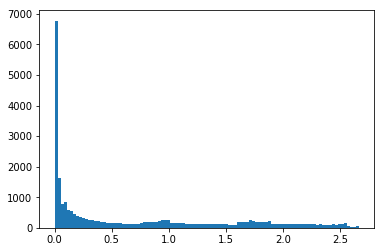

In [43]:
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
#tof_wave0 = np.array(pd.read_hdf(file_name, key='MC/tof_waveforms'), dtype='int')
tof_wave  = load_mcTOFsns_response(file_name)

for evt in range(1):
    waveforms = tof_wave[tof_wave.event_id == evt]
    #sns_ids   = - waveforms.sensor_id.values - first_sipm
    #times     =   waveforms.time_bin .values
    #charges   =   waveforms.charge   .values
    pe_table  = np.zeros((time_window, n_sipms))
    for i, wf in waveforms.iterrows():
        if wf.time_bin < time_window:
            s_id = - wf.sensor_id - first_sipm
            pe_table[wf.time_bin, s_id] = wf.charge
    #for s_id, t, c in zip(sns_ids, times, charges):
    #    if t < time_window:
    #        pe_table[t, s_id] = c
            
    conv_table = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    no_conv_table = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    
    #for i in range(n_sipms):
    for i in range(90, 91):
        if np.count_nonzero(pe_table[:,i]):
            conv_table[:,i] = convolve_tof(spe_resp, pe_table[0:time_window,i]) ##len(conv_table[:,i]) = 25999
            zeros_spe_resp  = np.zeros(len(spe_resp))
            no_conv_table[:,i] = convolve_tof(zeros_spe_resp, pe_table[0:time_window,i])
            print(conv_table[:,i])
            plt.hist(conv_table[:,i], bins=100)
            plt.show()
            #print(no_conv_table[:,i])

#    timestamp_v = []
#    for i in range(n_sipms):
#        timestamp  = np.argwhere(conv_table[0:time_window,i] > TE_TDC)
#        # We take only the first part up to time_window to speed up the computation
#        if len(timestamp)==0:
#            timestamp = 0
#        else:
#            timestamp = np.min(timestamp)
#
#        timestamp_v.append(timestamp)
#    timestamp_v = np.array(timestamp_v)  ## Array with the first time for each sensor
#    
#    part_acc = np.zeros(n_sipms)
#    for i, wf in waveforms.iterrows():
#        s_id = - wf.sensor_id - first_sipm
#        part_acc[s_id] += wf.charge
#
#

In [13]:
waveforms = tof_wave[tof_wave.event_id == 0]
sns_ids   = - waveforms.sensor_id.values - first_sipm
times     =   waveforms.time_bin .values
charges   =   waveforms.charge   .values
pe_table  = np.zeros((time_window, n_sipms))
for s_id, t, c in zip(sns_ids, times, charges):
    if t < time_window:
        pe_table[t, s_id] = c
        
conv_table = np.zeros((len(sns_ids) + len(spe_resp)-1, n_sipms))
print(len(conv_table))
signal     = pe_table[:time_window, 90] ## Array for times of each sensor
#conv_table[:,46] = convolve_tof(spe_resp, pe_table[0:time_window,46])

### convolve_tof function:
conv_first = np.hstack([spe_resp, np.zeros(len(signal)-1)])
conv_res   = np.zeros(len(signal)+len(spe_resp)-1)
pe_pos     = np.argwhere(signal > 0)
pe_recov   = signal[pe_pos]
for i in range(len(pe_recov)): #Loop over the charges
    desp     = np.roll(conv_first, pe_pos[i])*pe_recov[i]
    conv_res = desp + conv_res
    print(len(conv_res))


16527
25999
25999
25999
25999
25999
25999


### Call

In [14]:
a = np.ma.array([1,2,3], mask=[False, False, True])
a

masked_array(data=[1, 2, --],
             mask=[False, False,  True],
       fill_value=999999)

In [16]:
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_wave  = np.array(pd.read_hdf(file_name, key='MC/tof_waveforms'), dtype='int')

for evt in range(1):
    event_select   = np.argwhere(tof_wave [:,0]==evt)
    event_tof      = tof_wave[event_select[:,0],1:] ## Array with s_id, time and charge
    event_tof[:,0] = - event_tof[:,0] - first_sipm #Sensor ids (make them be positive and starting from zero)
    pe_table       = np.zeros((time_window, n_sipms))

    for i in range(event_tof.shape[0]):
        if event_tof[i,1] < time_window:
            #print(event_tof[i,1])
            pe_table[event_tof[i,1], event_tof[i,0]] = event_tof[i,2]

    conv_table = np.zeros((pe_table.shape[0] + spe_resp.shape[0]-1, n_sipms))

    for i in range(n_sipms):
        if not np.all(pe_table[:,i]==0): #np.max(pe_table[:,i])>0:
            conv_table[:,i] = convolve_tof(spe_resp, pe_table[0:time_window,i])

    timestamp_v = np.array([])
    for i in range(conv_table.shape[1]):
        timestamp  = np.argwhere(conv_table[0:time_window,i]>TE_TDC)
        # We take only the first part up to time_window to speed up the computation
        if timestamp.size == 0:
            timestamp = 0
        else:
            timestamp  = np.min(timestamp)

        timestamp_v = np.hstack([timestamp_v,timestamp])

    part_acc = np.zeros(n_sipms)
    for i in range(event_tof.shape[0]):
        part_acc[event_tof[i,0]] += event_tof[i,2]
        
    timestamp_M = np.ma.MaskedArray(timestamp,timestamp<1)
    gamma1_sipm = np.ma.argmin(timestamp_M)
    gamma1_tdc  = np.ma.min(timestamp_M)
    gamma2_sipm = np.zeros(gamma1_sipm.shape)
    gamma2_tdc  = np.zeros(gamma1_sipm.shape)

    gamma1_coord = np.where(SiPM_Matrix_O==gamma1_sipm)

    # Roll SiPM Matrixes to find opposite side of detector
    Xe = np.roll(SiPM_Matrix_O,-gamma1_coord[1]+ring_dim[1]//4,axis=1)
    # Select opposite side of detector
    Xe_sel = Xe[:,ring_dim[1]//2:]
    Xe_sel_1D = Xe_sel.reshape(-1)

    # Select first side of detector
    Xd_sel = Xe[:,0:ring_dim[1]//2]
    Xd_sel_1D = Xd_sel.reshape(-1)

    Xe_ener = np.sum(part_acc[Xe_sel_1D])
    Xd_ener = np.sum(part_acc[Xd_sel_1D])

IndexError: index 3537 is out of bounds for axis 1 with size 3500

In [33]:
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_wave  = load_mcTOFsns_response(file_name)

for evt in range(1):
    waveforms = tof_wave[tof_wave.event_id == evt]
    pe_table  = np.zeros((time_window, n_sipms))
    for i, wf in waveforms.iterrows():
        if wf.time_bin < time_window:
            s_id = - wf.sensor_id - first_sipm
            pe_table[wf.time_bin, s_id] = wf.charge
            
    conv_table = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    #for i in range(n_sipms):
    for i in range(90, 91):
        if np.count_nonzero(pe_table[:,i]):
            #conv_table[:,i] = convolve_tof(spe_resp, pe_table[0:time_window,i]) ##len(conv_table[:,i]) = 25999
            print(len(convolve_tof(spe_resp, pe_table[0:time_window,i])))


Len spe_resp 16000
Len signal 10000
Len conv_first 25999
desp 25999
desp 25999
desp 25999
desp 25999
desp 25999
desp 25999
25999
25999
